<a href="https://colab.research.google.com/github/raz0208/Advance-Quantitative-Research-Project/blob/main/Task3/Credit_Risk_Analysis_and_Modeling_PD_and_EL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 3: Credit Risk Analysis and Credit Risk Modeling**
### Predicting Probability of Default (PD) and Expected Loss (EL) for retail banking personal loans.

## **Step 1: data prepration**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and read dataset
df = pd.read_csv('/content/Task 3 and 4_Loan_Data.csv')
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


Data Description:
Shape of the dataset: (10000, 8)

Data Types:
customer_id         int64
credit_lines        int64
loan_amt          float64
total_debt        float64
income            float64
years_employed      int64
fico_score          int64
default             int64
dtype: object

Summary Statistics:
        customer_id  credit_lines      loan_amt    total_debt         income  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   4.974577e+06      1.461200   4159.677034   8718.916797   70039.901401   
std    2.293890e+06      1.743846   1421.399078   6627.164762   20072.214143   
min    1.000324e+06      0.000000     46.783973     31.652732    1000.000000   
25%    2.977661e+06      0.000000   3154.235371   4199.836020   56539.867903   
50%    4.989502e+06      1.000000   4052.377228   6732.407217   70085.826330   
75%    6.967210e+06      2.000000   5052.898103  11272.263740   83429.166133   
max    8.999789e+06      5.000000  10750.677810  4368

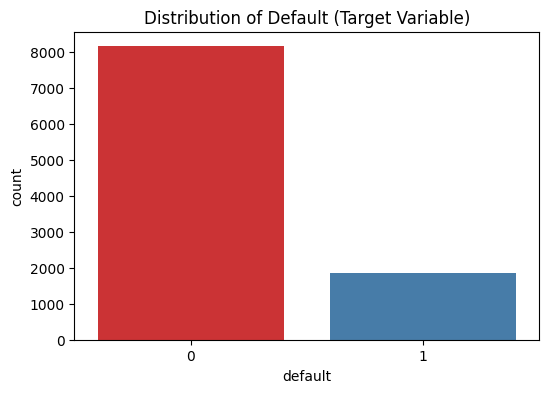

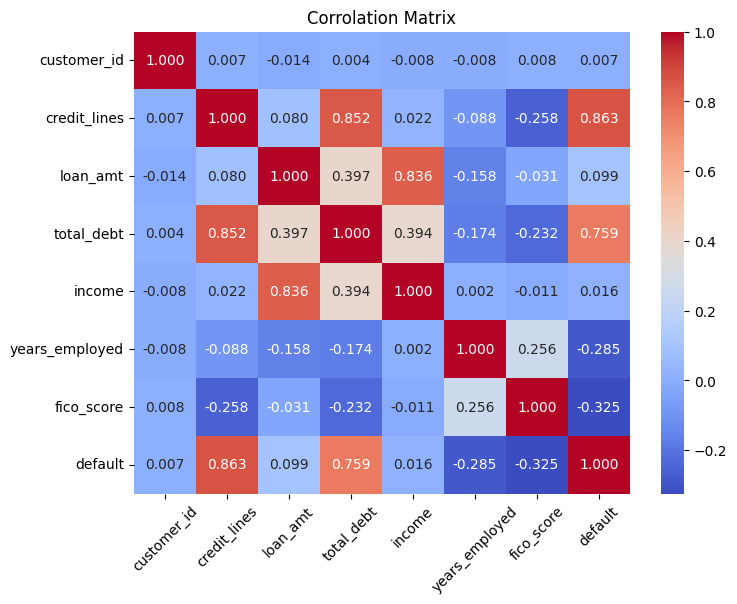

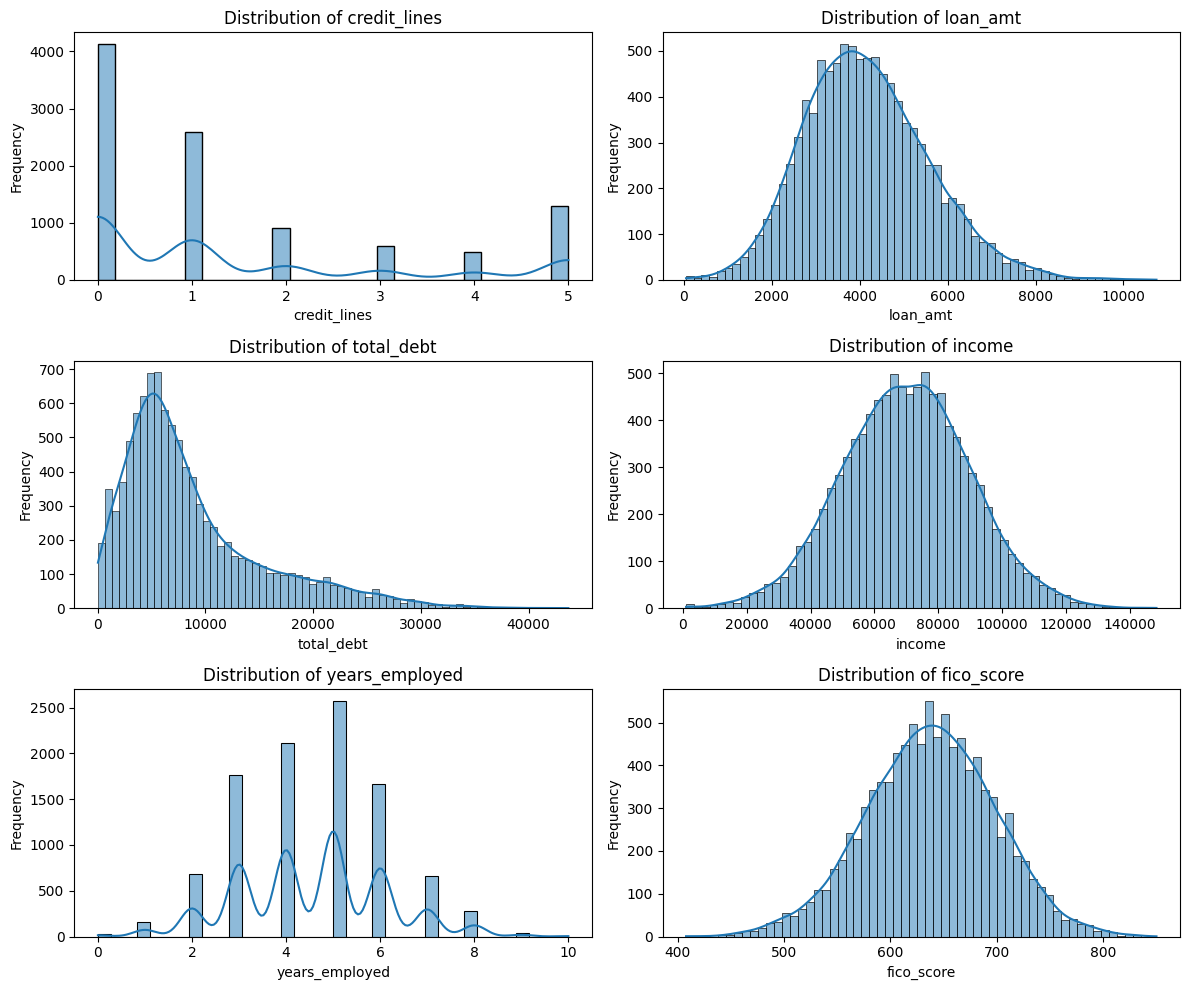

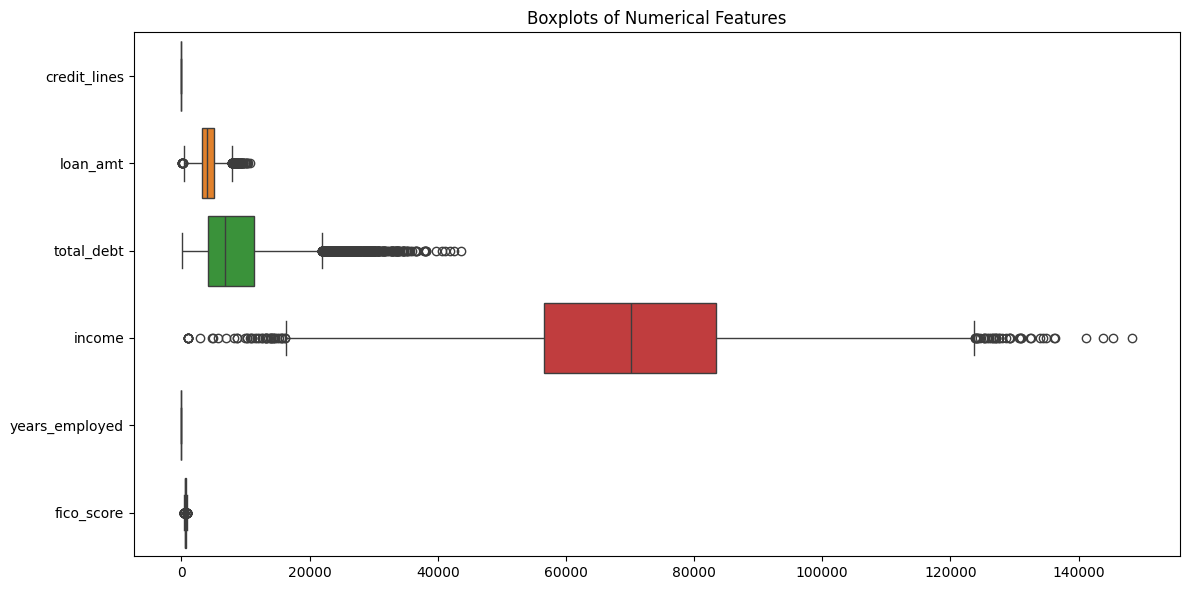

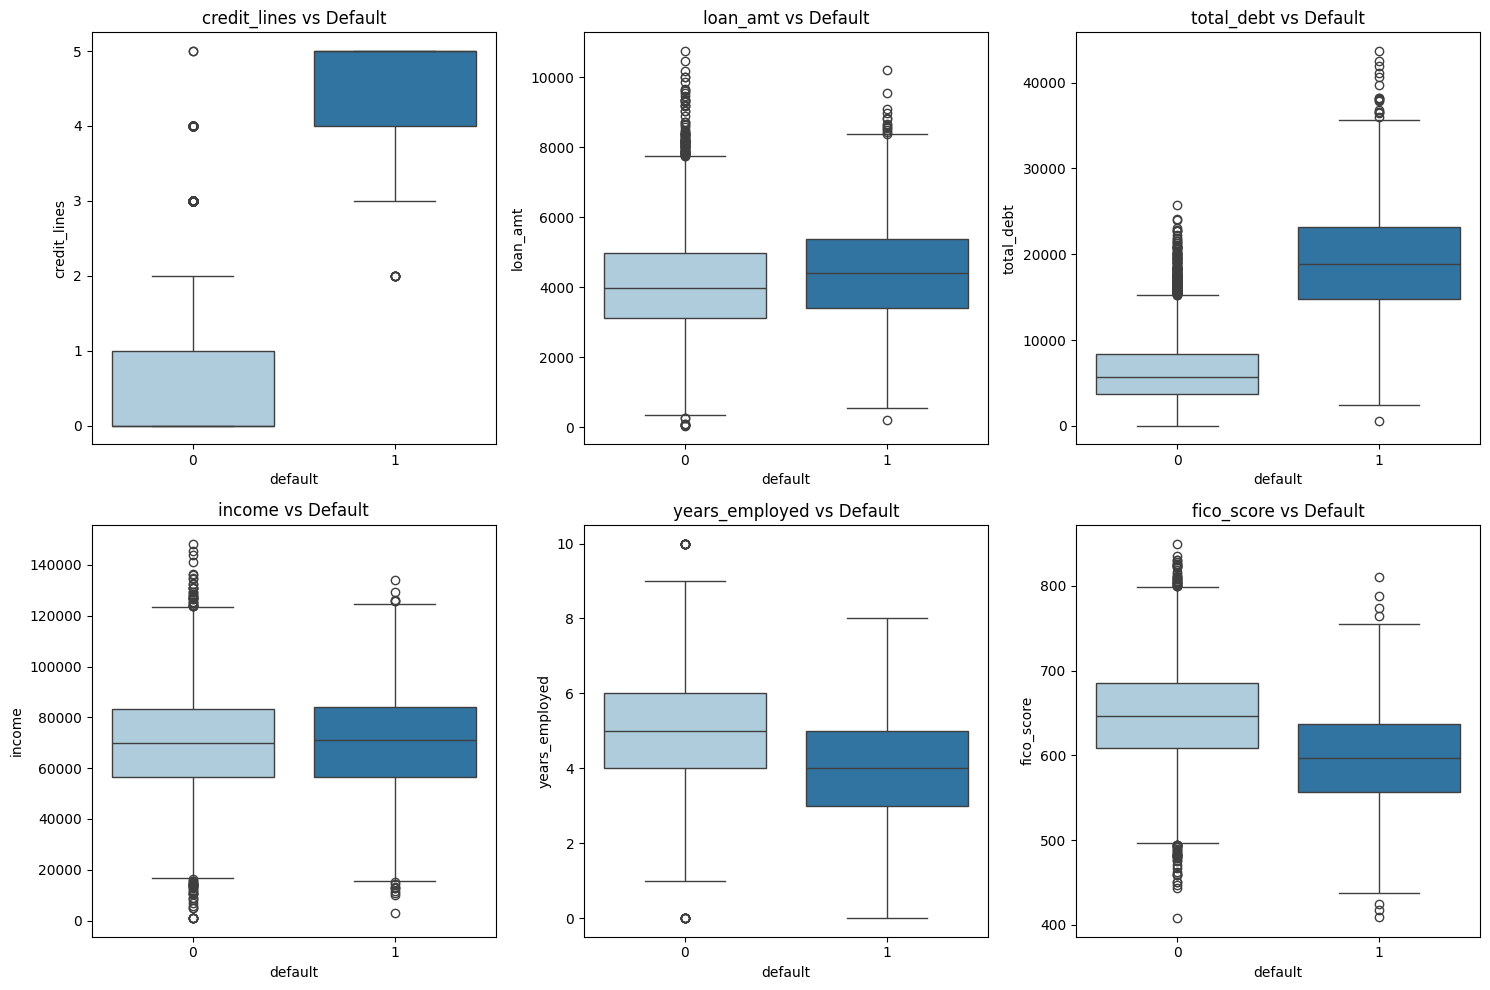

In [25]:
# Function to data understanding
def data_understanding(df):
  print("Data Description:")
  print(f"Shape of the dataset: {df.shape}")
  print("\nData Types:")
  print(df.dtypes)
  print("\nSummary Statistics:")
  print(df.describe())

  print("\nData Quality Verification:")
  # Check for missing values
  missing_val = df.isnull().sum()
  print(missing_val)

  # Check for duplication
  duplicates = df.duplicated().sum()
  print(f"\nNumber of duplicate rows: {duplicates}")
  print("\n")

  ## Data Exploration

  # Target variable distribution
  plt.figure(figsize=(6, 4))
  sns.countplot(x='default', data=df, palette ='Set1')
  plt.title('Distribution of Default (Target Variable)')
  plt.show()
  print("\n")

  # Corrolation matrix
  plt.figure(figsize=(8, 6))
  corrolation = df.corr()
  sns.heatmap(corrolation, annot=True, cmap='coolwarm', fmt='.3f')
  plt.title('Corrolation Matrix')
  plt.xticks(rotation=45)
  plt.show()
  print("\n")

  # Select columns
  numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.drop(['customer_id', 'default'])

  # # Histogram for Numerical Variables
  # df[numerical_columns].hist(figsize=(12, 10), bins=40, edgecolor='black')
  # plt.suptitle('Histograms of Numerical Features')
  # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  # plt.show()
  # print("\n")

  # plot histogram with sns for numerical_columns
  plt.figure(figsize=(12, 10))
  for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
  plt.tight_layout()
  plt.show()
  print("\n")

  # Boxplots for Outlier Detection
  plt.figure(figsize=(12, 6))
  sns.boxplot(data=df[numerical_columns], orient="h")
  plt.title("Boxplots of Numerical Features")
  plt.tight_layout()
  plt.show()
  print("\n")

  # Boxplot of Feature vs Default
  plt.figure(figsize=(15, 10))
  sns.color_palette("pastel")
  for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='default', y=col, data=df, palette='Paired')
    plt.title(f"{col} vs Default")
  plt.tight_layout()
  plt.show()
  print("\n")


# Remove "_outstanding" word from columns name where exists
for col in df.columns:
    if "_outstanding" in col:
        df.rename(columns={col: col.replace("_outstanding", "")}, inplace=True)

# Call the data_understanding function
data_understanding(df)

## **Dataset Prepration**

**Feature extraction**
 - **Debt-to-Income Ratio (DTI):** Measures the percentage of a borrower's gross income that goes toward paying debts.
 - **Loan-to-Income Ratio (LTI):** Measures the size of the loan relative to the borrower's income.
 - **Proportion of Loan in Total Debt:** Indicates how significant this specific loan is compared to their total debt load.
 - **Log Transformation (to handle skewness):** Adding 1 to avoid `log(0)`

In [27]:
# Feature Extraction/Engineering Function
def feature_extraction(data):
    """
    Performs feature engineering on the loan dataset.

    Args: data (pd.DataFrame): The input dataframe containing loan data.

    Returns: pd.DataFrame: The dataframe with new features added and customer_id removed.
    """
    # Create a copy of the dataframe
    df_fe = data.copy()

    # Debt-to-Income Ratio (DTI)
    df_fe['dti_ratio'] = df_fe['total_debt'] / df_fe['income']

    # Loan-to-Income Ratio (LTI)
    df_fe['loan_to_income'] = df_fe['loan_amt'] / df_fe['income']

    # Credit utilization proxy
    df_fe["credit_utilization"] = df_fe['credit_lines'] / (df_fe['credit_lines'].max()+1)

    # Proportion of Loan in Total Debt
    df_fe['loan_to_total_debt'] = df_fe['loan_amt'] / df_fe['total_debt']

    # Log Transformation (to handle skewness)
    df_fe['log_income'] = np.log1p(df_fe['income'])
    df_fe['log_total_debt'] = np.log1p(df_fe['total_debt'])

    # Drop customer_id as it's an identifier, if it exists
    if 'customer_id' in df_fe.columns:
        df_fe = df_fe.drop(columns=['customer_id'])

    return df_fe

# Call function
df_fe = feature_extraction(df)
df_fe

,credit_lines,loan_amt,total_debt,income,years_employed,fico_score,default,dti_ratio,loan_to_income,credit_utilization,loan_to_total_debt,log_income,log_total_debt
0,0,5221.545193,3915.471226,78039.38546,5,605,0,0.050173,0.066909,0.000000,1.333568,11.264982,8.272946
1,5,1958.928726,8228.752520,26648.43525,2,572,1,0.308789,0.073510,0.833333,0.238059,10.190523,9.015511
2,0,3363.009259,2027.830850,65866.71246,4,602,0,0.030787,0.051058,0.000000,1.658427,11.095404,7.615215
3,0,4766.648001,2501.730397,74356.88347,5,612,0,0.033645,0.064105,0.000000,1.905340,11.216645,7.825138
4,1,1345.827718,1768.826187,23448.32631,6,631,0,0.075435,0.057395,0.166667,0.760859,10.062597,7.478637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,3033.647103,2553.733144,42691.62787,5,697,0,0.059818,0.071060,0.000000,1.187926,10.661782,7.845703
9996,1,4146.239304,5458.163525,79969.50521,8,615,0,0.068253,0.051848,0.166667,0.759640,11.289413,8.605051
9997,2,3088.223727,4813.090925,38192.67591,5,596,0,0.126021,0.080859,0.333333,0.641630,10.550425,8.479303
9998,0,3288.901666,1043.099660,50929.37206,2,647,0,0.020481,0.064578,0.000000,3.153008,10.838215,6.950910


## **Model Implementaion**

Start with `Logistic Regression` to set a benchmark. Then, implement `LightGBM` or `XGBoost` to capture non-linear patterns. Compare them using `ROC-AUC` and `Brier Score` (accuracy of the probability).

**Recommended Practical Strategy. Best combination task:**
 - `Logistic Regression (LR)` → baseline & explainability
 - `LightGBM` or `GBM` → performance model
 - `Random Forest (RF)` → robustness check

 - Compare using `AUC`, `KS`, `Brier Score`
 - Calibrate probabilities
 - Use `PD × EAD × (1 − Recovery Rate)` for Expected Loss



Help you choose evaluation metrics

Design a model comparison pipeline

### **Logistic Regression: Industry Standard & Interpretability.**

In banking and credit risk, explainability is paramount (often a regulatory requirement). `Logistic Regression` provides clear coefficients that explain how a factor affects risk (e.g., "for every 10 points drop in FICO, risk increases by X%").

Since the `income` and `loan_amt` variables have **low linear correlation** with the target, a standard `Logistic Regression` might underperform unless you explicitly engineer features (like creating a `Debt-to-Income` ratio column).

 - Industry gold standard for PD modeling (Basel / IRB frameworks)
 - Outputs well-calibrated probabilities
 - Highly interpretable (coefficients → risk drivers)
 - Easy to explain to risk managers and regulators
 - Works very well on structured financial data

### **Gradient Boosting: Performance & Handling Non-Linearity.**
 - LightGBM
 - GBM
 - XGBoost

These models are currently **state-of-the-art** for tabular data. They automatically learn complex interactions (like the relationship between `income` and `debt`) without needing manual feature engineering. They usually offer the highest predictive accuracy (`AUC/Gini`).

This is likely the challenger/best performing model. `LightGBM` is particularly fast and efficient.
 - Excellent performance on tabular, nonlinear data
 - Captures interactions between borrower characteristics
 - Often best accuracy / AUC in credit risk problems
 - Produces strong PD ranking (important for loss estimation)

### **Random Forest: Robustness & Stability.**

It performs similarly to `Gradient Boosting` but is less prone to overfitting and easier to tune. It handles non-linearities well.
 - Robust and stable
 - Handles nonlinearities and interactions automatically
 - Less sensitive to noise than single trees

### **Bayesian Logistic Regression**

 - Probabilistic framework → uncertainty estimation

Useful when:
 - Dataset is small
 - You want regularization + uncertainty
 - Conceptually aligned with risk modeling